In [1]:
!git clone https://github.com/njucckevin/SeeClick.git

fatal: destination path 'SeeClick' already exists and is not an empty directory.


In [2]:
pip install -r SeeClick/requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Initialize the model

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig

# NOTE: Qwen-VL scales the resolution to 448 so that it can be evaluated end-to-end!
# TODO: Use/fine-tune Qwen-VL-Max, which supports large resolution input images?
# https://github.com/QwenLM/Qwen-VL

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", device_map={"":1}, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("cckevinn/SeeClick", device_map={"":1}, trust_remote_code=True, bf16=True).eval()
model.generation_config = GenerationConfig.from_pretrained("Qwen/Qwen-VL-Chat", device_map={"":1}, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

Proompt:  In this UI screenshot, what is the position of the element corresponding to View menu (with point)?
Finished in 392.421 milliseconds!
Original image:


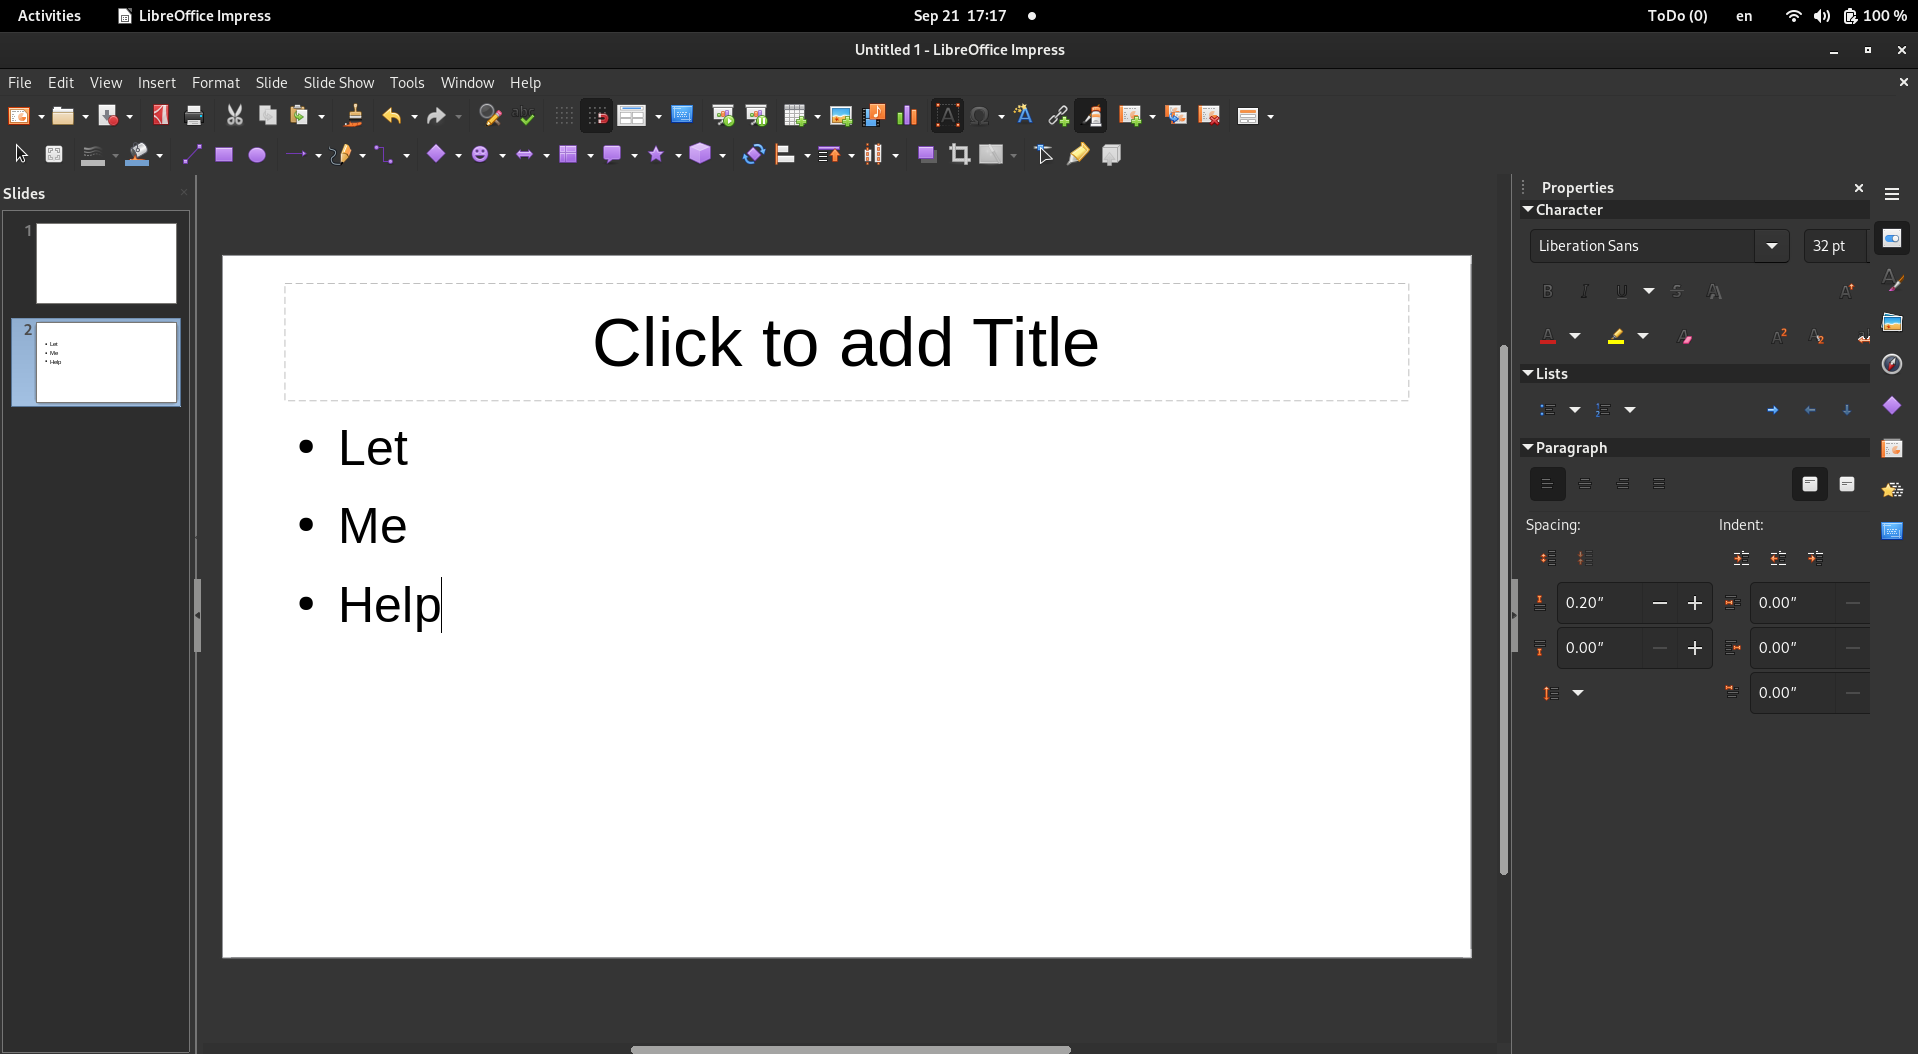

Image resolution (pixels):  1918 1054
Model response:  (0.06,0.11)
x, y coordinates (pixels):  115.08 115.94


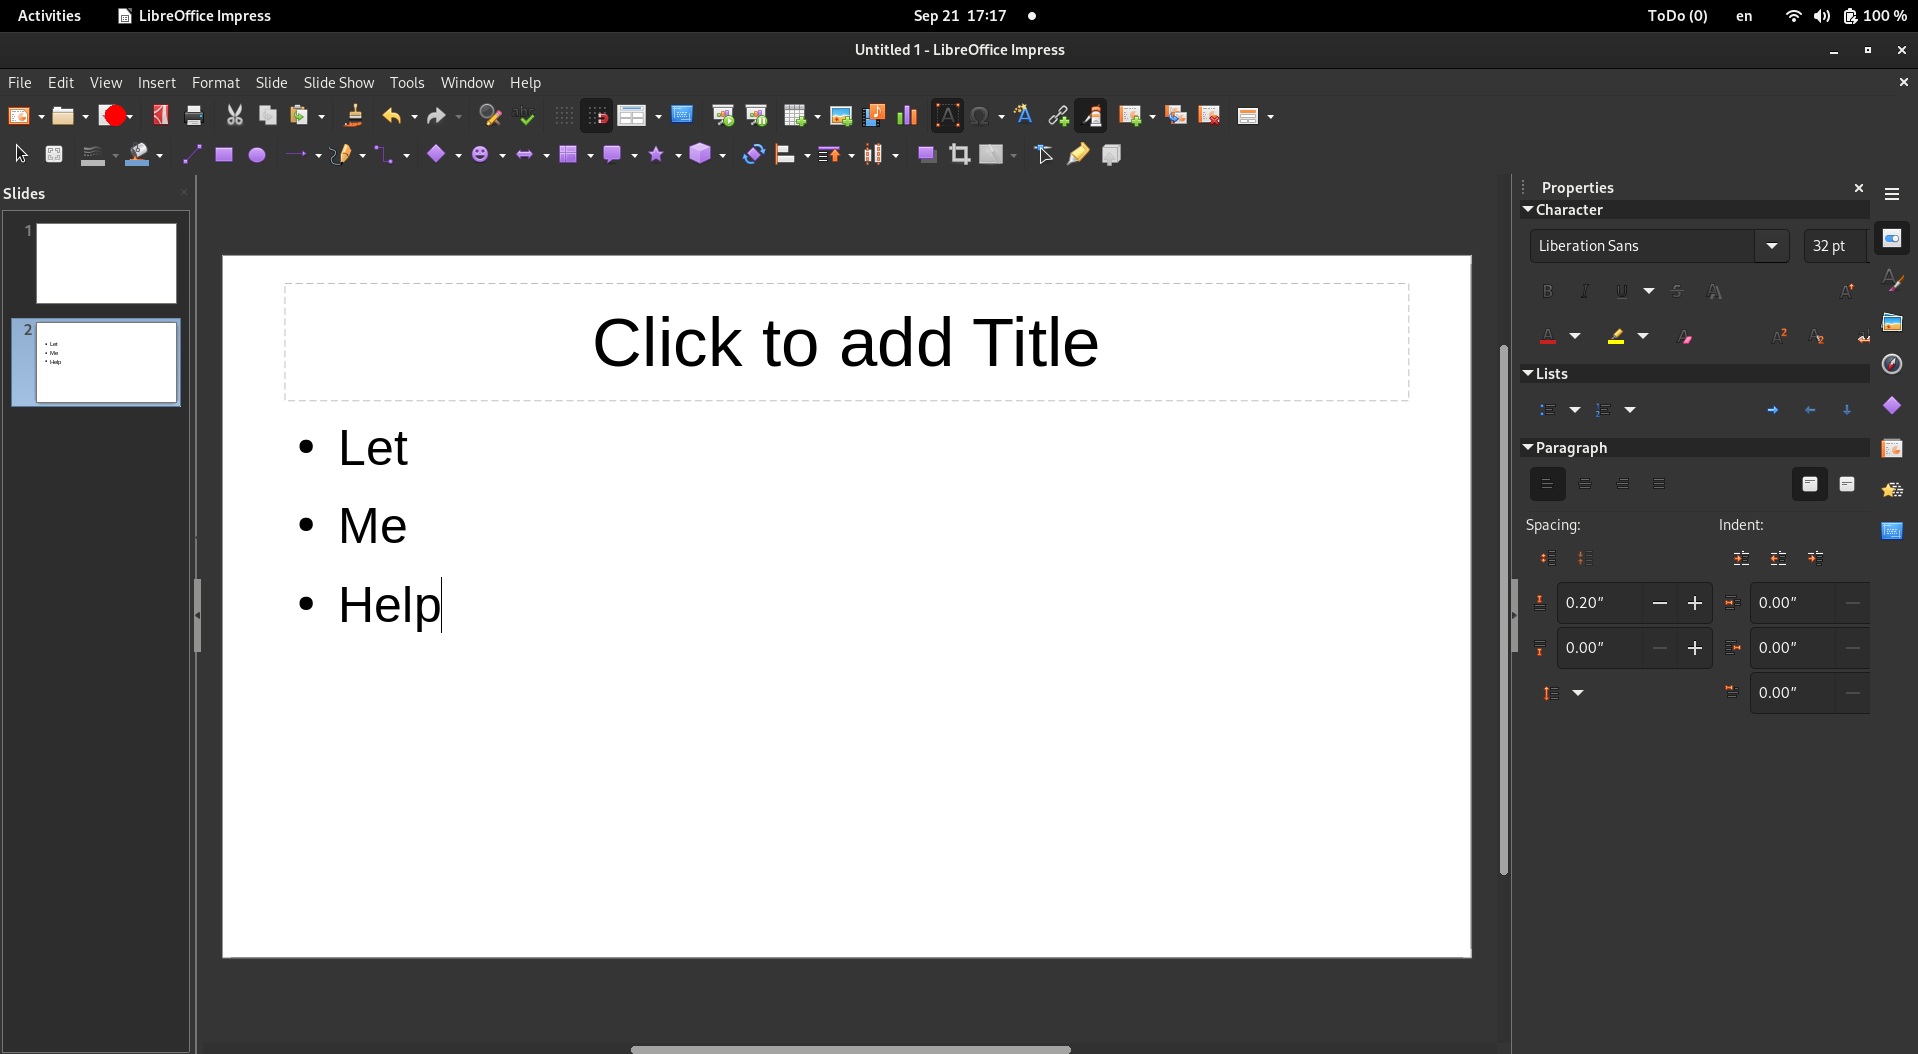

In [80]:
# Run inference and time it
import decimal

from datetime import datetime
from PIL import Image, ImageDraw
from IPython.display import display

startTime = datetime.now()

# Possible values: bbox, point
output_type = "point"
target_ui_element = "View menu"

img_path = "screenshot1.png"
# Prompt from https://github.com/njucckevin/SeeClick/blob/main/pretrain/screenspot_test.py#L52
prompt = "In this UI screenshot, what is the position of the element corresponding to {} (with {})?".format(target_ui_element, output_type) # or (with point)
query = tokenizer.from_list_format([
    {'image': img_path},
    {'text': prompt},
])
# Temperature has to be a positive float :/
response, history = model.chat(tokenizer, query=query, history=None, temperature = 1.0)

print("Proompt: ", prompt)
print("Finished in {} milliseconds!".format((datetime.now() - startTime).microseconds / 1000))

# Original image size (pixels)
im = Image.open(img_path)
width, height = im.size
print("Original image:")
display(im)
print("Image resolution (pixels): ", width, height)

# The prediction output represents the point of (x, y) or the bounding box of (left, top, right, down), each value is a [0, 1] decimal number indicating the ratio of the corresponding position to the width or height of the image. 
# For the View menu: (0.05,0.07,0.07,0.09)
print("Model response: ", response)


# Confirm the results

# Convert the bounding box response from [0, 1] to the original 
# Format: (left, top, right, down)
response = response.replace("(", "")
response = response.replace(")", "")

if output_type == "bbox":
    bbox_coordinates = [decimal.Decimal(x.strip()) for x in response.split(',')]
    left = bbox_coordinates[0] * width
    top = bbox_coordinates[1] * height
    right = bbox_coordinates[2] * width
    down = bbox_coordinates[3] * height
    print("left, top, right, down coordinates (pixels): ", left, top, right, down)
    
    # Draw dots on the screenshot
    draw = ImageDraw.Draw(im)
    draw.rectangle([left, top, right, down], outline="red")
    display(im)

    # Cut it out
    im2 = im.crop((left, top, right, down))
    display(im2)
elif output_type == "point":
    point_coordinates = [decimal.Decimal(x.strip()) for x in response.split(',')]
    x = point_coordinates[0] * width
    y = point_coordinates[1] * height
    print("x, y coordinates (pixels): ", x, y)

    # Draw on the screenshot
    draw = ImageDraw.Draw(im)
    radius = 10
    leftUpPoint = (x-radius, y-radius)
    rightDownPoint = (x+radius, y+radius)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, fill=(255,0,0,255))
    display(im)